In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

## Data Preparation

In [3]:
root_path = os.path.abspath(os.path.dirname(os.getcwd()))
train_path = os.path.join(root_path, "data/train")

file_ids = ['1', '2', '3', '4', '6', '7', '8', '9', '10', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60']
global_run_data = pd.read_parquet(os.path.join(train_path, f"run_data_{file_ids[0]}.parquet"))
global_incoming_run_data = pd.read_parquet(os.path.join(train_path, f"incoming_run_data_{file_ids[0]}.parquet"))
global_metrology_data = pd.read_parquet(os.path.join(train_path, f"metrology_data{file_ids[0]}.parquet"))

for file_id in tqdm(file_ids):
    if file_id == '1':
        continue
    temp_run_data = pd.read_parquet(os.path.join(train_path, f"run_data_{file_id}.parquet"))
    temp_incoming_run_data = pd.read_parquet(os.path.join(train_path, f"incoming_run_data_{file_id}.parquet"))
    temp_metrology_data = pd.read_parquet(os.path.join(train_path, f"metrology_data{file_id}.parquet"))

    global_run_data = pd.concat([global_run_data, temp_run_data], ignore_index=True)
    global_incoming_run_data = pd.concat([global_incoming_run_data, temp_incoming_run_data], ignore_index=True)
    global_metrology_data = pd.concat([global_metrology_data, temp_metrology_data], ignore_index=True)

100%|██████████| 19/19 [00:44<00:00,  2.32s/it]


In [3]:
# Round all datetime to the nearest second (reason: parquet format does not support 64-bit datetime)
global_run_data['Run Start Time'] = global_run_data['Run Start Time'].dt.round('s')
global_run_data['Run End Time'] = global_run_data['Run End Time'].dt.round('s')
global_run_data['Time Stamp'] = global_run_data['Time Stamp'].dt.round('s')

global_incoming_run_data['Run Start Time'] = global_incoming_run_data['Run Start Time'].dt.round('s')
global_incoming_run_data['Run End Time'] = global_incoming_run_data['Run End Time'].dt.round('s')
global_incoming_run_data['Time Stamp'] = global_incoming_run_data['Time Stamp'].dt.round('s')

global_metrology_data['Run Start Time'] = global_metrology_data['Run Start Time'].dt.round('s')
global_metrology_data['Run End Time'] = global_metrology_data['Run End Time'].dt.round('s')

In [4]:
global_run_data.to_parquet('global_run_data.parquet')
global_incoming_run_data.to_parquet('global_incoming_run_data.parquet')
global_metrology_data.to_parquet('global_metrology_data.parquet')

## Preprocessor

In [5]:
global_run_data = pd.read_parquet('global_run_data.parquet')
global_incoming_run_data = pd.read_parquet('global_incoming_run_data.parquet')
global_metrology_data = pd.read_parquet('global_metrology_data.parquet')

### Run Data

In [6]:
# Drop `Process Step`
global_run_data = global_run_data.drop(columns=['Process Step'])

# Drop `Run End Time`
global_run_data = global_run_data.drop(columns=['Run End Time'])

# # Replace `Run End Time` with duration of the run and rename it to `Run Duration`
# global_run_data['Run End Time'] = (global_run_data['Run End Time'] - global_run_data['Run Start Time']).dt.total_seconds().astype(int)
# global_run_data.rename(columns={'Run End Time': 'Run Duration'}, inplace=True)

# Replace `Run Start Time` with seconds elapsed since the start of the first run
# TODO: Try using the earliest starting time across both datasets
start_time = global_run_data['Run Start Time'].min()
global_run_data['Run Start Time'] = (global_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)

# Replace `Time Stamp` with seconds elapsed since the start of the first run
global_run_data['Time Stamp'] = (global_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)

# Categorical labeling
# Tool ID is global
tool_id_cat = global_run_data['Tool ID'].astype('category')
tool_id_mapping = dict(enumerate(tool_id_cat.cat.categories))
global_run_data['Tool ID'] = tool_id_cat.cat.codes

# Run ID is global
run_id_cat = global_run_data['Run ID'].astype('category')
run_id_mapping = dict(enumerate(run_id_cat.cat.categories))
global_run_data['Run ID'] = run_id_cat.cat.codes

# Step ID is local
global_run_data['Step ID'] = global_run_data['Step ID'].astype('category').cat.codes

# Sensor Name is local
global_run_data['Sensor Name'] = global_run_data['Sensor Name'].astype('category').cat.codes


In [7]:
print(global_run_data.head(5))

   Tool ID  Run Start Time  Run ID  Consumable Life  Step ID  Time Stamp  \
0        8               0    1644         370.7229        0           0   
1        8               0    1644         370.7229        0           1   
2        8               0    1644         370.7229        0           2   
3        8               0    1644         370.7229        1           3   
4        8               0    1644         370.7229        1           4   

   Sensor Name  Sensor Value  
0            0     -0.061105  
1            0     -0.040894  
2            0      0.005357  
3            0     -0.029941  
4            0     -0.098098  


### Incoming Run Data

In [8]:
# Drop `Process Step`
global_incoming_run_data = global_incoming_run_data.drop(columns=['Process Step'])

# Drop `Run End Time`
global_incoming_run_data = global_incoming_run_data.drop(columns=['Run End Time'])

# # Replace `Run End Time` with duration of the run and rename it to `Run Duration`
# global_incoming_run_data['Run End Time'] = (global_incoming_run_data['Run End Time'] - global_incoming_run_data['Run Start Time']).dt.total_seconds().astype(int)
# global_incoming_run_data.rename(columns={'Run End Time': 'Run Duration'}, inplace=True)

# Replace `Run Start Time` with seconds elapsed since the start of the first run
# TODO: Try using the earliest starting time across both datasets
start_time = global_incoming_run_data['Run Start Time'].min()
global_incoming_run_data['Run Start Time'] = (global_incoming_run_data['Run Start Time'] - start_time).dt.total_seconds().astype(int)

# Replace `Time Stamp` with seconds elapsed since the start of the first run
global_incoming_run_data['Time Stamp'] = (global_incoming_run_data['Time Stamp'] - start_time).dt.total_seconds().round().astype(int)

# Categorical labeling
# Tool ID is global
incoming_tool_id_cat = global_incoming_run_data['Tool ID'].astype('category')
incoming_tool_id_mapping = dict(enumerate(incoming_tool_id_cat.cat.categories))
global_incoming_run_data['Tool ID'] = incoming_tool_id_cat.cat.codes
assert incoming_tool_id_mapping == tool_id_mapping

# Run ID is global
incoming_run_id_cat = global_incoming_run_data['Run ID'].astype('category')
incoming_run_id_mapping = dict(enumerate(incoming_run_id_cat.cat.categories))
global_incoming_run_data['Run ID'] = incoming_run_id_cat.cat.codes
assert incoming_run_id_mapping == run_id_mapping

# Step ID is local
global_incoming_run_data['Step ID'] = global_incoming_run_data['Step ID'].astype('category').cat.codes

# Sensor Name is local
global_incoming_run_data['Sensor Name'] = global_incoming_run_data['Sensor Name'].astype('category').cat.codes

In [9]:
print(global_incoming_run_data.head(5))

   Tool ID  Run Start Time  Run ID  Step ID  Time Stamp  Sensor Name  \
0        8               0    1644        0           0            0   
1        8               0    1644        0           1            0   
2        8               0    1644        0           2            0   
3        8               0    1644        1           3            0   
4        8               0    1644        1           4            0   

   Sensor Value  
0    202.660553  
1    202.660553  
2    202.660553  
3    202.660553  
4    202.660553  


### Metrology Data

In [10]:
# Run ID is global
metrology_run_id_cat = global_metrology_data['Run ID'].astype('category')
metrology_run_id_mapping = dict(enumerate(metrology_run_id_cat.cat.categories))
global_metrology_data['Run ID'] = metrology_run_id_cat.cat.codes
assert metrology_run_id_mapping == run_id_mapping

# Drop Run Start Time, Run End Time, X, Y and Point Index
global_metrology_data = global_metrology_data.drop(columns=['Run Start Time', 'Run End Time', 'X', 'Y', 'X_index', 'Y_index'])

In [11]:
print(global_metrology_data.head(5))

   Run ID  Point Index  Measurement
0       8            3    10.006534
1       8           48    10.002181
2       8           43    10.031223
3       8           20    10.055888
4       8            8    10.089505


### Serialization

In [12]:
global_run_data.to_parquet('processed_global_run_data.parquet')
global_incoming_run_data.to_parquet('processed_global_incoming_run_data.parquet')
global_metrology_data.to_parquet('processed_global_metrology_data.parquet')

## Model Input Preparation

In [4]:
processed_global_run_data = pd.read_parquet('processed_global_run_data.parquet')
processed_global_incoming_run_data = pd.read_parquet('processed_global_incoming_run_data.parquet')
processed_global_metrology_data = pd.read_parquet('processed_global_metrology_data.parquet')

### Process `run_data`

In [36]:
# train_run_data = processed_global_run_data.groupby('Run ID').get_group(1644).pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value')

# run_matrices_df = None
# run_matrices = []

# tool_id_categories = processed_global_run_data['Tool ID'].astype('category').cat.categories.tolist()
# tool_id_to_index = {cat: i for i, cat in enumerate(tool_id_categories)}
# num_tool_ids = len(tool_id_categories)
# print(num_tool_ids)
# for key, run in processed_global_run_data.groupby('Run ID'):
#     run_matrix = run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
#     run_matrix['Run Start Time'] = run['Run Start Time'].iloc[0]
#     run_matrix['Consumable Life'] = run['Consumable Life'].iloc[0]
#     run_matrix['Step ID'] = run['Step ID'].iloc[0]
#     run_matrix['Tool ID'] = run['Tool ID'].iloc[0] # TODO: one-hot encode Tool ID

#     cols = run_matrix.columns.tolist()
#     cols.insert(0, cols.pop(cols.index('Run Start Time')))
#     cols.insert(0, cols.pop(cols.index('Step ID')))
#     cols.insert(0, cols.pop(cols.index('Tool ID')))
#     run_matrix = run_matrix[cols]

#     if run_matrices_df is None:
#         run_matrices_df = run_matrix.reindex(range(755), fill_value=0.0).copy()
#     run_matrix = run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
#     run_matrices.append(run_matrix)

# run_matrices = np.stack(run_matrices)
# print(run_matrices.shape)

run_matrices_df = None
run_matrices = []

# Step 1: 准备所有可能的 Tool ID 类别（只做一次）
tool_id_categories = processed_global_run_data['Tool ID'].astype('category').cat.categories.tolist()
tool_id_to_index = {cat: i for i, cat in enumerate(tool_id_categories)}
num_tool_ids = len(tool_id_categories)

for key, run in processed_global_run_data.groupby('Run ID'):
    # Pivot 出 sensor 数据
    run_matrix = run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
    
    # 添加其他列（常数列）
    run_matrix['Run Start Time'] = run['Run Start Time'].iloc[0]
    run_matrix['Consumable Life'] = run['Consumable Life'].iloc[0]
    run_matrix['Step ID'] = run['Step ID'].iloc[0]
    tool_id = run['Tool ID'].iloc[0]

    # One-hot 编码 Tool ID
    tool_index = tool_id_to_index[tool_id]
    tool_onehot = np.zeros(num_tool_ids)
    tool_onehot[tool_index] = 1
    tool_onehot_df = pd.DataFrame([tool_onehot] * len(run_matrix), columns=[f'ToolID_{cat}' for cat in tool_id_categories])

    # 删除 Tool ID 列（不再使用原始数值）
    # 注意：Tool ID 还没加进去过，只是作为变量处理，不用 drop

    # 构建目标列顺序：Step ID, Run Start Time, Time Stamp + one-hot + sensor columns
    run_matrix = pd.concat([
        tool_onehot_df,                                           # one-hot
        run_matrix  # 剩下 sensor + consumable
    ], axis=1)
    
    cols = run_matrix.columns.tolist()
    cols.insert(0, cols.pop(cols.index('Run Start Time')))
    cols.insert(0, cols.pop(cols.index('Step ID')))
    
    run_matrix = run_matrix[cols]
    
    
    # 填补 padding 到 755
    if run_matrices_df is None:
        run_matrices_df = run_matrix.reindex(range(755), fill_value=0.0).copy()

    run_matrix = run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    run_matrices.append(run_matrix)

run_matrices = np.stack(run_matrices)
print(run_matrices.shape)







(4140, 755, 38)


In [6]:
run_matrices_df

Sensor Name,Tool ID,Step ID,Run Start Time,Time Stamp,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,Consumable Life
0,18.0,0.0,67655.0,67655.0,0.031361,-685.860962,43.201454,-0.062989,0.096825,199.516937,19.552303,321.102417,302.841675,349.080383,0.067108,0.046422,713.761169,747.554504,769.712463,270.084137
1,18.0,0.0,67655.0,67656.0,-0.012847,1033.420654,49.187046,0.047596,0.090925,198.919159,20.790668,349.450714,330.221710,379.608734,0.109856,-0.056719,776.895081,814.807068,837.206055,270.084137
2,18.0,0.0,67655.0,67657.0,0.009782,55674.625000,98.741898,0.001774,0.084763,199.439133,31.275209,377.232452,356.137665,411.858246,0.077752,-0.028565,838.632385,879.301880,907.878174,270.084137
3,18.0,0.0,67655.0,67658.0,0.030168,-9624.925781,98.783913,-0.010263,0.102715,198.240219,32.151119,378.474884,356.320068,410.731934,0.111437,-0.003759,841.154785,879.696106,905.663452,270.084137
4,18.0,0.0,67655.0,67659.0,0.020838,2319.374023,98.922531,0.042651,0.069815,198.713242,32.410534,377.695648,356.672089,410.337097,0.112087,-0.012833,839.642944,880.184509,904.920410,270.084137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
751,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
752,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
753,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [37]:
run_matrices_df

,Step ID,Run Start Time,ToolID_0,ToolID_1,ToolID_2,ToolID_3,ToolID_4,ToolID_5,ToolID_6,ToolID_7,...,6,7,8,9,10,11,12,13,14,Consumable Life
0,0.0,67655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,19.552303,321.102417,302.841675,349.080383,0.067108,0.046422,713.761169,747.554504,769.712463,270.084137
1,0.0,67655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,20.790668,349.450714,330.221710,379.608734,0.109856,-0.056719,776.895081,814.807068,837.206055,270.084137
2,0.0,67655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,31.275209,377.232452,356.137665,411.858246,0.077752,-0.028565,838.632385,879.301880,907.878174,270.084137
3,0.0,67655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.151119,378.474884,356.320068,410.731934,0.111437,-0.003759,841.154785,879.696106,905.663452,270.084137
4,0.0,67655.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.410534,377.695648,356.672089,410.337097,0.112087,-0.012833,839.642944,880.184509,904.920410,270.084137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [7]:
print(run_matrices[0, 0, :])

[ 1.80000000e+01  0.00000000e+00  6.76550000e+04  6.76550000e+04
  3.13611105e-02 -6.85860962e+02  4.32014542e+01 -6.29886463e-02
  9.68251526e-02  1.99516937e+02  1.95523033e+01  3.21102417e+02
  3.02841675e+02  3.49080383e+02  6.71078935e-02  4.64224853e-02
  7.13761169e+02  7.47554504e+02  7.69712463e+02  2.70084137e+02]


In [16]:
print(run_matrices[0, 0, :])

[ 0.00000000e+00  6.76550000e+04  6.76550000e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  3.13611105e-02 -6.85860962e+02
  4.32014542e+01 -6.29886463e-02  9.68251526e-02  1.99516937e+02
  1.95523033e+01  3.21102417e+02  3.02841675e+02  3.49080383e+02
  6.71078935e-02  4.64224853e-02  7.13761169e+02  7.47554504e+02
  7.69712463e+02  2.70084137e+02]


### Process `incoming_run_data`

In [17]:
processed_global_incoming_run_data.head()

,Tool ID,Run Start Time,Run ID,Step ID,Time Stamp,Sensor Name,Sensor Value
0,8,0,1644,0,0,0,202.660553
1,8,0,1644,0,1,0,202.660553
2,8,0,1644,0,2,0,202.660553
3,8,0,1644,1,3,0,202.660553
4,8,0,1644,1,4,0,202.660553


In [ ]:
# incoming_run_matrices_df = None
# incoming_run_matrices = []
# for key, incoming_run in processed_global_incoming_run_data.groupby('Run ID'):
#     incoming_run_matrix = incoming_run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)
#     incoming_run_matrix['Run Start Time'] = incoming_run['Run Start Time'].iloc[0]
#     incoming_run_matrix['Step ID'] = incoming_run['Step ID'].iloc[0]
#     incoming_run_matrix['Tool ID'] = incoming_run['Tool ID'].iloc[0] # TODO: try deleting/one-hot encoding Tool ID

#     cols = incoming_run_matrix.columns.tolist()
#     cols.insert(0, cols.pop(cols.index('Run Start Time')))
#     cols.insert(0, cols.pop(cols.index('Step ID')))
#     cols.insert(0, cols.pop(cols.index('Tool ID')))
#     incoming_run_matrix = incoming_run_matrix[cols]

#     if incoming_run_matrices_df is None:
#         incoming_run_matrices_df = incoming_run_matrix.reindex(range(755), fill_value=0.0).copy()
#     incoming_run_matrix = incoming_run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
#     incoming_run_matrices.append(incoming_run_matrix)

# incoming_run_matrices = np.stack(incoming_run_matrices)
# print(incoming_run_matrices.shape)

incoming_run_matrices_df = None
incoming_run_matrices = []

# Step 1: 准备 Tool ID 的所有类别（和 run_matrix 共用同一套）
tool_id_categories = processed_global_incoming_run_data['Tool ID'].astype('category').cat.categories.tolist()
tool_id_to_index = {cat: i for i, cat in enumerate(tool_id_categories)}
num_tool_ids = len(tool_id_categories)

for key, incoming_run in processed_global_incoming_run_data.groupby('Run ID'):
    # Pivot 出 sensor 值
    incoming_run_matrix = incoming_run.pivot(index='Time Stamp', columns='Sensor Name', values='Sensor Value').reset_index(drop=False)

    # 添加元信息（每一行都一样）
    incoming_run_matrix['Run Start Time'] = incoming_run['Run Start Time'].iloc[0]
    incoming_run_matrix['Step ID'] = incoming_run['Step ID'].iloc[0]
    tool_id = incoming_run['Tool ID'].iloc[0]

    # One-hot 编码 Tool ID
    tool_index = tool_id_to_index[tool_id]
    tool_onehot = np.zeros(num_tool_ids)
    tool_onehot[tool_index] = 1
    tool_onehot_df = pd.DataFrame([tool_onehot] * len(incoming_run_matrix), columns=[f'ToolID_{cat}' for cat in tool_id_categories])

    # 构建列顺序
    incoming_run_matrix = pd.concat([
        incoming_run_matrix[['Step ID', 'Run Start Time', 'Time Stamp']],       # 前3列（顺序固定）
        tool_onehot_df,                                                         # One-hot 插入位置
        incoming_run_matrix.drop(columns=['Step ID', 'Run Start Time', 'Time Stamp'])  # Sensor 数据
    ], axis=1)

    # Padding 到 755 行
    if incoming_run_matrices_df is None:
        incoming_run_matrices_df = incoming_run_matrix.reindex(range(755), fill_value=0.0).copy()

    incoming_run_matrix = incoming_run_matrix.reindex(range(755), fill_value=0.0).to_numpy()
    incoming_run_matrices.append(incoming_run_matrix)

incoming_run_matrices = np.stack(incoming_run_matrices)
print(incoming_run_matrices.shape)


(4140, 755, 63)


In [19]:
incoming_run_matrices_df

,Step ID,Run Start Time,Time Stamp,ToolID_0,ToolID_1,ToolID_2,ToolID_3,ToolID_4,ToolID_5,ToolID_6,...,31,32,33,34,35,36,37,38,39,40
0,0.0,82564.0,82564.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,32.095299,55.331364,1027.537598,2.934873,50.230888,-0.331318,24.738844,2.890625,33.760548,58.363422
1,0.0,82564.0,82565.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,37.061600,66.677788,1027.244385,3.249969,67.682472,0.311291,24.680222,2.859916,41.801453,66.625519
2,0.0,82564.0,82566.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,45.634243,80.886696,1027.415161,3.047924,80.018761,-0.169987,24.754717,3.179736,49.503643,79.410126
3,0.0,82564.0,82567.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,82.552429,149.393250,1027.698853,3.136262,86.356590,0.145812,24.717636,3.227875,91.218178,153.468552
4,0.0,82564.0,82568.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,85.161224,148.640625,1027.756958,3.044295,86.283775,-0.097708,24.819736,3.384035,93.501106,154.447861
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
750,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
752,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
753,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [20]:
print(incoming_run_matrices[0, 0, :])

[ 0.00000000e+00  8.25640000e+04  8.25640000e+04  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.00000000e+00  2.06448059e+02 -3.86409616e+00
 -8.01727116e-01  4.86098442e+01  9.49880886e+00  4.20048237e-01
  4.50297070e+00  8.82590088e+02  1.68778553e+01  9.57505417e+01
 -1.31489173e-01  7.83298828e+02  2.07790674e+03  4.32936859e+00
  3.12357845e+01  1.84935880e+00  1.55615845e+02  2.59801426e+01
  5.00202141e+01 -5.73219657e-01  9.07108917e+01  2.46390629e+01
  1.94097729e+01  4.68600243e-02  3.00300079e+02  7.86665466e+02
  2.57429600e+00  5.47670484e-01  7.77703629e+01  5.11192902e+02
  2.00354140e-02  3.20952988e+01  5.53313637e+01  1.02753760e+03
  2.93487310e+00  5.02308884e+01 -3.31317842e-01  2.47388439e+01
  2.89062476e+00  3.37605

### Process `metrology_data`

In [21]:
processed_global_metrology_data.head()

,Run ID,Point Index,Measurement
0,8,3,10.006534
1,8,48,10.002181
2,8,43,10.031223
3,8,20,10.055888
4,8,8,10.089505


In [22]:
metrology_matrix = processed_global_metrology_data.pivot(index='Run ID', columns='Point Index', values='Measurement')
metrology_matrix = metrology_matrix.to_numpy()
print(metrology_matrix.shape)

(4140, 49)


### Serialization

In [23]:
root_path = os.path.abspath(os.path.dirname(os.getcwd()))
processed_path = os.path.join(root_path, "data", "processed")
os.makedirs(processed_path, exist_ok=True)

In [24]:
from joblib import dump, load
dump(run_matrices, os.path.join(processed_path, 'run_matrices_onehot.joblib'))
dump(incoming_run_matrices, os.path.join(processed_path, 'incoming_run_matrices_onehot.joblib'))
dump(metrology_matrix, os.path.join(processed_path, 'metrology_matrix_onehot.joblib'))

['d:\\Work\\micron_data\\MicronDataChallenge\\micro-ai-challenge\\data\\processed\\metrology_matrix_onehot.joblib']

## Miscellaneous

In [25]:
start_times = global_run_data.groupby('Run ID')['Run Start Time'].min().values
consumable_lives = global_run_data.groupby('Run ID')['Consumable Life'].min().values

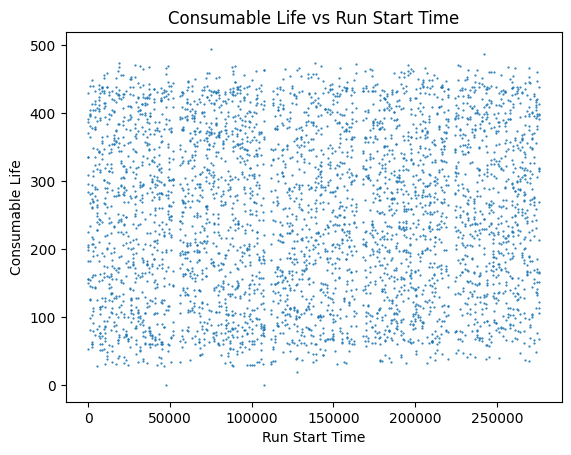

In [26]:
plt.scatter(start_times, consumable_lives, s=0.3)
plt.xlabel('Run Start Time')
plt.ylabel('Consumable Life')
plt.title('Consumable Life vs Run Start Time')
plt.show()

In [27]:
global_run_data_snap_to_seconds = global_run_data.copy()
global_run_data_snap_to_seconds['Time Stamp'] = global_run_data_snap_to_seconds['Time Stamp'].dt.round('s')

AttributeError: Can only use .dt accessor with datetimelike values

Text(0.5, 1.0, 'Distribution of Time Stamps')

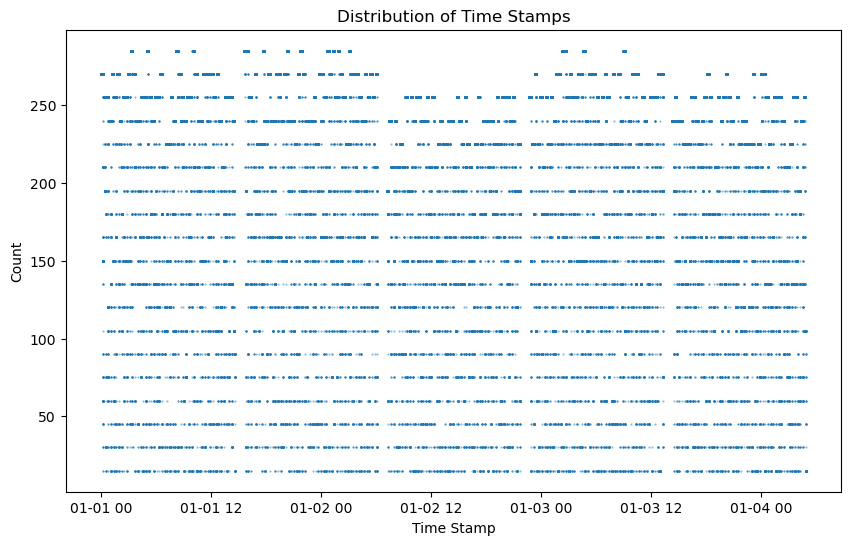

In [ ]:
plt.figure(figsize=(10, 6))
counts = global_run_data_snap_to_seconds['Time Stamp'].value_counts().sort_index()
plt.scatter(counts.index, counts.values, alpha=0.5, s=0.3)
plt.xlabel('Time Stamp')
plt.ylabel('Count')
plt.title('Distribution of Time Stamps')
plt.show()

(array([18.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0., 16.,  0.,
         0.,  0., 18.,  0.,  0.,  0., 17.,  0.,  0., 18.,  0.,  0.,  0.,
        16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0., 18.,
         0.,  0.,  0., 19.,  0.,  0., 18.,  0.,  0.,  0., 16.,  0.,  0.,
         0., 16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0.,
        19.,  0.,  0., 17.,  0.,  0.,  0., 16.,  0.,  0.,  0., 17.,  0.,
         0.,  0., 17.,  0.,  0.,  0., 18.,  0.,  0., 14.,  0.,  0.,  0.,
        15.,  0.,  0.,  0., 15.,  0.,  0.,  0., 17.,  0.,  0.,  0., 16.,
         0.,  0.,  0., 19.,  0.,  0., 18.,  0.,  0.,  0., 17.,  0.,  0.,
         0., 16.,  0.,  0.,  0., 17.,  0.,  0.,  0., 17.,  0.,  0.,  0.,
        19.,  0.,  0., 18.,  0.,  0.,  0., 16.,  0.,  0.,  0., 16.,  0.,
         0.,  0., 18.,  0.,  0.,  0., 18.,  0.,  0., 18.,  0.,  0.,  0.,
        18.,  0.,  0.,  0., 17.,  0.,  0.,  0., 18.,  0.,  0.,  0., 16.,
         0.,  0.,  0., 14.,  0.,  0., 17.,  0.,  0.

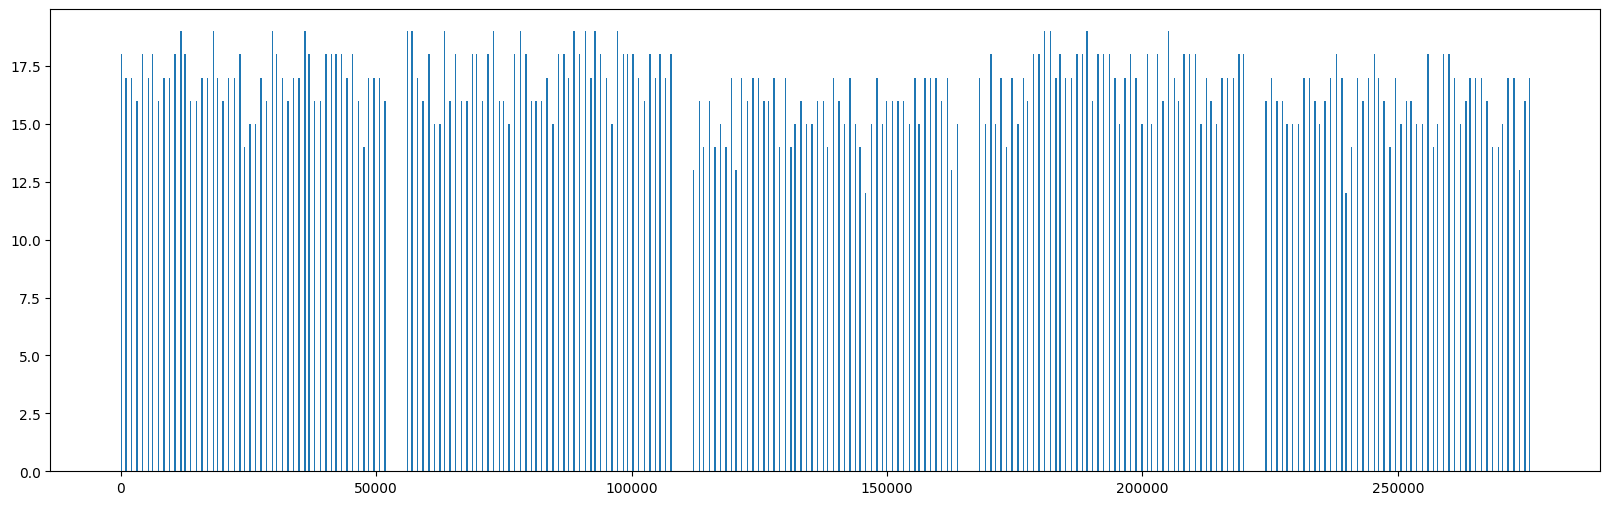

In [28]:
plt.figure(figsize=(20, 6))
plt.hist(global_run_data.groupby('Run ID')['Run Start Time'].min().values, bins=1000)